# Chapter 10: Sparse matrices and graphs

Robert Johansson

Updated source code listings for Numerical Python - A Practical Techniques Approach for Industry (ISBN 978-1-484205-54-9).

Updator: Kee-Youn Yoo

For matrices that are dominated by elements that are zero, it is inefficient to store all the zeros in the
computer's memory, and it is more suitable to store only the nonzero values with additional information
about their locations. For non-sparse matrices, known as dense matrices, such a representation is less efficient
than storing all values consecutively in the memory, but for large *sparse* matrices it can be vastly superior.

There are several options for working with sparse matrices in Python. Here we mainly focus on the sparse
matrix module in Scipy, `scipy.sparse`, which provides an easy-to-use interface for representing
sparse matrices and carrying out linear algebra operations on such objects. Toward the end of the chapter, we also briefly explore representing and processing graphs, using the Scipy `sparse.csgraph` module and the NetworkX library. Graphs can be represented as adjacency matrices, which in many applications are very sparse. Graphs and sparse matrices are therefore closely connected topics.

## Importing modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

import numpy as np
import scipy.linalg as la

import scipy.sparse as sp
import scipy.sparse.linalg

import networkx as nx

## Sparse matrices in scipy

The basic idea of sparse matrix representation is to avoid storing the excessive amount of zeros in a
sparse matrix. if we store only the nonzero elements, we clearly also
need to store the row and column indices for each element. There are numerous approaches to organizing
the storage of the nonzero elements and their corresponding row and column indices.

The class `sp.coo_matrix` is used to represent sparse matrices in the coordinate list format. This format is particularly easy to initialize. For instance, with the matrix,

\begin{bmatrix}
0 & 1 & 0 & 0\\ 
0 & 0 & 0 & 2\\ 
0 & 0 & 3 & 0\\ 
4 & 0 & 0 & 0
\end{bmatrix},

we can easily identify the nonzero values $[A_{01}=1,\,A_{13}=2,\,A_{22}=3,\,A_{30}=4]$ and their corresponding rows
$[0, 1, 2, 3]$ and columns $[1, 3, 2, 0]$ (note that here we have used Python’s zero-based indexing).

In [2]:
values = [1, 2, 3, 4]

rows = [0, 1, 2, 3]
cols = [1, 3, 2, 0]

A = sp.coo_matrix((values, (rows, cols)), shape=[4, 4]); A

<4x4 sparse matrix of type '<class 'numpy.int32'>'
	with 4 stored elements in COOrdinate format>

The result is a data structure that represents the sparse matrix. All sparse matrix representations in
Scipy's `sparse` module share several common attributes. Examples of such attributes are `shape`, `size`,`dtype`, and `ndim`, and common to all sparse matrix representations are the `nnz` (number of nonzero elements) and `data` (the nonzero values) attributes:

In [3]:
A.shape, A.size, A.dtype, A.ndim

((4, 4), 4, dtype('int32'), 2)

In [4]:
A.nnz, A.data

(4, array([1, 2, 3, 4]))

In [5]:
A.row, A.col

(array([0, 1, 2, 3], dtype=int32), array([1, 3, 2, 0], dtype=int32))

There are also a large number of methods available for operating on sparse matrix objects. Many of
these methods are for applying mathematical functions on the matrix. For example, element-wise math
methods like `sin`, `cos`, `arcsin`, etc., aggregation methods like `min`, `max`, `sum`, etc., mathematical array
operators such as conjugate (`conj`) and transpose (`transpose`), etc., and `dot` for computing the dot product
between sparse matrices or a sparse matrix and a dense vector.

Another important family of methods is used to convert sparse matrices
between different formats: For example `tocoo`, `tocsr`, `tolil`, etc. There are also the methods for converting a
sparse matrix to Numpy `ndarray` and Numpy `matrix` objects (that is, dense matrix representations): `toarray`
and `todense`, respectively.

In [6]:
A.tocsr()

<4x4 sparse matrix of type '<class 'numpy.int32'>'
	with 4 stored elements in Compressed Sparse Row format>

In [7]:
A.toarray()

array([[0, 1, 0, 0],
       [0, 0, 0, 2],
       [0, 0, 3, 0],
       [4, 0, 0, 0]], dtype=int32)

In [8]:
A.todense()

matrix([[0, 1, 0, 0],
        [0, 0, 0, 2],
        [0, 0, 3, 0],
        [4, 0, 0, 0]], dtype=int32)

The obvious way to access elements in a matrix, which we have used in numerous different contexts so
far, is using the indexing syntax, for example `A[1,2]`, as well as the slicing syntax, for example `A[1:3, 2]`,
and so on. We can often use this syntax with sparse matrices too, but not all representations support
indexing and slicing, and if it is supported it may not be an efficient operation.

In [9]:
A[1,2]

TypeError: 'coo_matrix' object is not subscriptable

In [10]:
A.tobsr()[1,2]

NotImplementedError: 

In [11]:
A.tocsr()[1,2]

0

In [12]:
A.tolil()[1:3,3]

<2x1 sparse matrix of type '<class 'numpy.int32'>'
	with 1 stored elements in LInked List format>

When working with sparse matrices, it is common to face the situation that different tasks – such
as construction, updating, and arithmetic operations – are most efficiently handled in different formats.
Converting between different sparse formats is a relatively efficient, so it is useful to switch between
different formats in different parts of an application. Efficient use of sparse matrices therefore requires an
understanding of how different formats are implemented and what they are suitable for. 

For computations, the most important sparse matrix representations in Scipy's `sparse` module are
the **CSR (Compressed Sparse Row)** and **CSC (Compressed Sparse Column)** formats, because they are well
suited for efficient matrix arithmetic and linear algebra applications. Other formats, like **COO**, **LIL** and **DOK**
are mainly used for constructing and updated sparse matrices, and once a sparse matrix is ready to be used
in computations, it is best to convert it to either CSR or CSC format, using the `tocsr` or `tocsc` methods,
respectively.

In the CSR format, the nonzero values (`data`) are stored along with an array that contains the column
indices of each value (`indices`), and another array that stores the offsets of the column index array of each
row with the total number of nonzero elements at the end(`indptr`). For instance, consider the matrix

\begin{bmatrix}
1 & 2 & 0 & 0\\ 
0 & 3 & 4 & 0\\ 
0 & 0 & 5 & 6\\ 
7 & 0 & 8 & 9
\end{bmatrix}

In [13]:
A = np.array([[1, 2, 0, 0], [0, 3, 4, 0], [0, 0, 5, 6], [7, 0, 8, 9]]); A

array([[1, 2, 0, 0],
       [0, 3, 4, 0],
       [0, 0, 5, 6],
       [7, 0, 8, 9]])

In [14]:
A = sp.csr_matrix(A)

In [15]:
A.data

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [16]:
A.indices

array([0, 1, 1, 2, 2, 3, 0, 2, 3], dtype=int32)

In [17]:
A.indptr

array([0, 2, 4, 6, 9], dtype=int32)

For example, the elements in the third row, with index `i=2`, starts at
`indptr[2]=4` and ends at `indptr[3]-1=5`, which gives the element values `data[4]=5` and `data[5]=6` and
column indices `indices[4]=2` and `indices[5]=3`. Thus, `A[2,2]= 5` and `A[2,3]= 6`:

In [18]:
i = 2
A.indptr[i], A.indptr[i+1]-1

(4, 5)

In [19]:
A.indices[A.indptr[i]:A.indptr[i+1]]

array([2, 3], dtype=int32)

In [20]:
A.data[A.indptr[i]:A.indptr[i+1]]

array([5, 6], dtype=int32)

In [21]:
A[2, 2], A[2, 3] # check

(5, 6)

### Functions for creating sparse matrices

As we have seen examples of earlier in this chapter, one way of constructing sparse matrices is to prepare the
data structures for a specific sparse matrix format, and pass these to the constructor of the corresponding
sparse matrix class. While this method is sometimes suitable, it is often more convenient to compose
sparse matrices from predefined template matrices

To create a sparse matrix of
size 10 x 10 with a main diagonal and an upper and lower diagonal, we can use three calls to `sp.eye`, using
the `k` argument to specify the offset from the main diagonal:

In [22]:
N = 10
A = sp.eye(N, k=1) - 2 * sp.eye(N) + sp.eye(N, k=-1); A

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

By default the resulting object is sparse matrix in the CSR format, but using the `format` argument, we
can specify any other sparse matrix format. All functions for creating sparse matrices in `sp.sparse` accept this argument.
For example, in the previous example we could have produced the same matrix using `sp.diags`, by specifying
the pattern `[1, -2, 1]`, and the corresponding offsets from the main diagonal `[1, 0, -1]`. If we additionally want the resulting sparse
matrix in CSC format, we can set `format='csc'`: 

In [23]:
A = sp.diags([1, -2, 1], [1, 0, -1], shape=[N, N], format='csc'); A

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Column format>

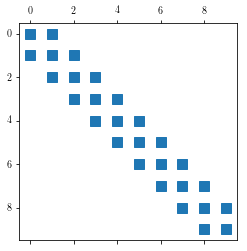

In [24]:
fig, ax = plt.subplots()
ax.spy(A);

For example, to create a sparse matrix for the tensor product between $A$ and the matrix

\begin{bmatrix}
0 & 1 & 0\\ 
1 & 0 & 1\\ 
0 & 1 & 0
\end{bmatrix}

we can use `sp.kron(A, B)`:

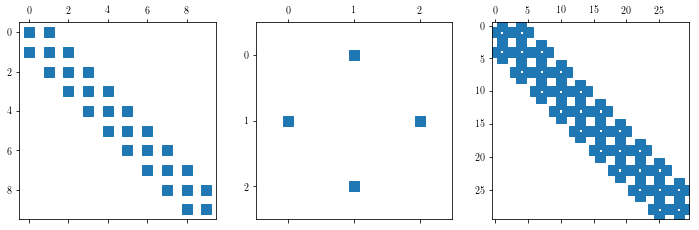

In [25]:
B = sp.diags([1, 1], [-1, 1], shape=[3,3])
C = sp.kron(A, B)

fig, (ax_A, ax_B, ax_C) = plt.subplots(1, 3, figsize=(12, 4))
ax_A.spy(A)
ax_B.spy(B)
ax_C.spy(C);

### Sparse linear algebra functions

The main application of sparse matrices is to perform linear algebra operations on large matrices that are
intractable or inefficient to treat using dense matrix representations.The Scipy `sparse` module contains a
module `linalg` that implements many linear algebra routines. Not all linear algebra operations are suitable
for sparse matrices, and in some cases the behavior of the sparse matrix version of operations needs to be
modified compared to the dense counterparts. Consequently, there are a number of differences between the
sparse linear algebra module `scipy.sparse.linalg` and the dense linear algebra module `scipy.linalg`.
In general, for sparse matrix methods to be efficient, they must retain the sparsity of matrices involved in the
computation. An examples of operations where the sparsity usually is not retained is the matrix inverse, and
it should therefore be avoided when possible.

### Linear equation systems

The most important application of sparse matrices is arguably to solve linear equation system on the form
$\mathbf{A}\mathbf{x} = \mathbf{b}$, where $\mathbf{A}$ is a sparse matrix and $\mathbf{x}$ and $\mathbf{b}$ are dense vectors. 
The Scipy `sparse.linalg` module has both
direct and iterative solver for this type of problem (`sp.linalg.spsolve`), and methods to factor a matrix $\mathbf{A}$,
using for example LU factorization (`sp.linalg.splu`) and incomplete LU factorization (`sp.linalg.spilu`).

In [26]:
N = 10
A = sp.diags([1, -2, 1], [1, 0, -1], shape=[N, N], format='csc')
b = -np.ones(N)

In [27]:
x = sp.linalg.spsolve(A, b); x

array([  5.,   9.,  12.,  14.,  15.,  15.,  14.,  12.,   9.,   5.])

For comparison, we can also solve this problem using
dense direct solver in Numpy `np.linalg.solve` (or, similarly, using `scipy.linalg.solve`).

In [28]:
np.linalg.solve(A.todense(), b)

array([  5.,   9.,  12.,  14.,  15.,  15.,  14.,  12.,   9.,   5.])

As expected, the result agrees with what we obtained from the sparse solver. For small problems like this
one there is not much to gain using sparse matrices, but for increasing system size the merits of using sparse
matrices and sparse solvers become apparent. For this particular problem, the threshold system size beyond
which using sparse methods outperforms dense methods is approximately N =100.

An alternative to the spsolve interface is to explicitly compute the LU factorization using `sp.sparse.splu`
or `sp.sparse.spilu` (incomplete LU factorization). These functions return an object that contains the $\mathbf{L}$ and
$\mathbf{U}$ factors, and that has a method solve that solves $\mathbf{LUx} = \mathbf{b}$ for a given vector $\mathbf{b}$.

In [29]:
lu = sp.linalg.splu(A)

In [30]:
lu.L

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Column format>

In [31]:
lu.U

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Column format>

In [32]:
x = lu.solve(b); x

array([  5.,   9.,  12.,  14.,  15.,  15.,  14.,  12.,   9.,   5.])

An important consideration that arises with sparse matrices is that the LU factorization of $\mathbf{A}$ may
introduce new nonzero elements in $\mathbf{L}$ and $\mathbf{U}$ compared to the matrix $\mathbf{A}$, and therefore make $\mathbf{L}$ and $\mathbf{U}$ less sparse. Elements that exist in $\mathbf{L}$ or $\mathbf{U}$, but not in $\mathbf{A}$, are called fill-ins. If the amount of fill-ins is large the
advantage of using sparse matrices may be lost. While there is no complete solution to eliminate fill-ins, it is
often possible to reduce fill-in by permuting the rows and columns in $\mathbf{A}$, so that the LU factorization takes
the form $\mathbf{P_r AP_c} = \mathbf{LU}$.

The `spsolve`, `splu` and `spilu` functions all take the
argument `permc_spec`, which can take the values `NATURAL`, `MMD_ATA`, `MMD_AT_PLUT_A`, or `COLAMD`, which
indicates different permutation methods that are built in in these methods. The object returned by `splu` and
`spilu` accounts for such permutations, and the permutation vectors are available via the `perm_c` and `perm_r`
attributes.

In [33]:
lu.L * lu.U - A

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Column format>

In [34]:
lu.perm_r

array([0, 1, 2, 3, 4, 5, 6, 8, 7, 9], dtype=int32)

In [35]:
lu.perm_c

array([0, 1, 2, 3, 4, 5, 6, 8, 7, 9], dtype=int32)

In [36]:
def sp_permute(A, perm_r, perm_c):
    """ permute rows and columns of A """
    M, N = A.shape
    # row permumation matrix
    Pr = sp.coo_matrix((np.ones(M), (perm_r, np.arange(N)))).tocsr()
    # column permutation matrix
    Pc = sp.coo_matrix((np.ones(M), (np.arange(M), perm_c))).tocsr()
    return Pr.T * A * Pc.T

In [37]:
sp_permute(lu.L * lu.U, lu.perm_r, lu.perm_c) - A

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Column format>

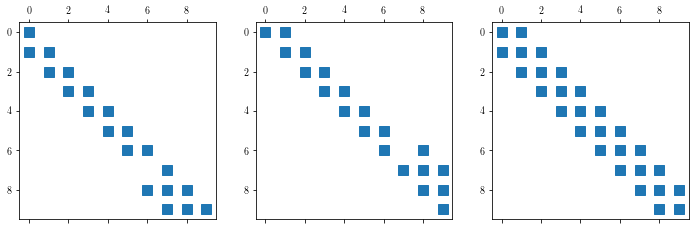

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.spy(lu.L)
ax2.spy(lu.U)
ax3.spy(A);

By default, the direct sparse linear solver in Scipy uses the `SuperLU` package. An alternative sparse
matrix solver that also can be used in Scipy is the `UMFPACK` package, although this package is not bundled
with Scipy and requires that the `scikit-umfpack` Python library is installed. If `scikit-umfpack` is available,
and if the `use_umfpack` argument to the `sp.linalg.spsolve` function is `True`, then the `UMFPACK` is used
instead of `SuperLU`. Whether `SuperLU` or `UMFPACK` gives better performance varies from problem to
problem, so it is worth having both installed and testing both for any given problem.

In [39]:
# use_umfpack=True is only effective if scikit-umfpack is installed
x = sp.linalg.spsolve(A, b, use_umfpack=True); x

array([  5.,   9.,  12.,  14.,  15.,  15.,  14.,  12.,   9.,   5.])

The `sp.spsolve` function is an interface to direct solvers, which internally performs matrix
factorization. An alternative approach is to use iterative methods that originate in optimization. The Scipy
`sparse.linalg` module contains several functions for iterative solution of sparse linear problems: For
example, `bicg` (biconjugate gradient method), `bicgstab` (biconjugate gradient stabilized method), `cg`
(conjugate gradient), `gmres` (generalized minimum residual), and `lgmres` (loose generalized minimum
residual method). All of these functions (and a few others) can be used to solve the problem $\mathbf{Ax} = \mathbf{b}$ by calling
the function with $\mathbf{A}$ and $\mathbf{b}$ as arguments, and they all return a tuple `(x, info)` where `x` is the solution and
`info` contains additional information about the solution process (`info=0` indicates success, and it is positive
for convergence error, and negative for input error). For example:

In [40]:
x, info = sp.linalg.bicgstab(A, b); x

array([  5.,   9.,  12.,  14.,  15.,  15.,  14.,  12.,   9.,   5.])

In [41]:
x, info = sp.linalg.cg(A, b); x

array([  5.,   9.,  12.,  14.,  15.,  15.,  14.,  12.,   9.,   5.])

In [42]:
x, info = sp.linalg.lgmres(A, b); x

array([  5.,   9.,  12.,  14.,  15.,  15.,  14.,  12.,   9.,   5.])

Iterative solver may have an advantage over direct solvers for very large problems,
where direct solvers may require excessive memory usage due to undesirable fill-ins. In contrast, iterative
solvers only require to evaluate sparse matrix-vector multiplications, and therefore do not suffer from fill-in
problems, but on the other hand they might have slow convergence for many problems, especially if not
properly preconditioned.

#### A matrix permutation method: reverse_cuthil_mcKee

In [43]:
N = 25
A = sp.diags([1, -2, 1], [8, 0, -8], shape=[N, N], format='csc')
perm = sp.csgraph.reverse_cuthill_mckee(A); perm

array([ 7, 15, 23,  1,  9, 17,  2, 10, 18,  3, 11, 19,  4, 12, 20,  5, 13,
       21,  6, 14, 22, 24, 16,  8,  0], dtype=int32)

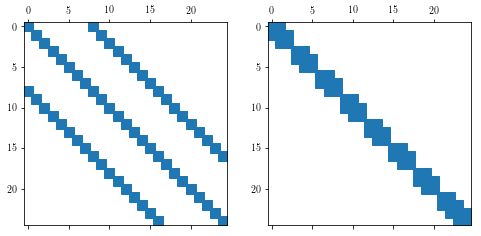

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.spy(A)
ax2.spy(sp_permute(A, perm, perm));

#### Performance comparison: Sparse/Dense

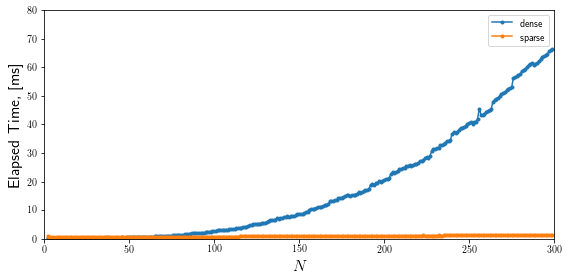

In [45]:
# compare performance of solving Ax=b vs system size N,
# where A is the sparse matrix for the 1d poisson problem
import time

def setup(N):
    A = sp.diags([1,-2,1], [1,0,-1], shape=[N, N], format='csr')
    b = -np.ones(N)
    return A, A.todense(), b

reps = 10

N_vec = np.arange(2, 300, 1)
t_sparse = np.empty(len(N_vec))
t_dense = np.empty(len(N_vec))
for idx, N in enumerate(N_vec):
    A, A_dense, b = setup(N)
    t = time.time()
    for r in range(reps):
        x = np.linalg.solve(A_dense, b)
    t_dense[idx] = (time.time() - t)/reps

    t = time.time()
    for r in range(reps):
        x = sp.linalg.spsolve(A, b, use_umfpack=True)
    t_sparse[idx] = (time.time() - t)/reps
    
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(N_vec, t_dense * 1e3, '.-', label="dense")
ax.plot(N_vec, t_sparse * 1e3, '.-', label="sparse")
ax.set_xlabel(r"$N$", fontsize=16)
ax.set_ylabel("Elapsed Time, [ms]", fontsize=16)
ax.legend(loc=0)

ax.set_xlim(0, 300)
ax.set_ylim(0, 80)

fig.tight_layout()

### Eigenvalue problems

Sparse eigenvalue and singular-value problems can be solved using the `sp.linalg.eigs` and `sp.linalg.svds`
functions, respectively. For real symmetric or complex hermitian matrices, the eigenvalues (which in this
case are real) and eigenvectors can also be computed using `sp.linalg.eigsh`. These functions do not
compute all eigenvalues or singular values, but rather compute a given number of eigenvalues and
vectors (the default is six).

For example, to compute the lowest four eigenvalues for the sparse matrix of the one-dimensional
Poisson problem (of system size 10 x 10),

In [46]:
N = 10
A = sp.diags([1, -2, 1], [1, 0, -1], shape=[N, N], format='csc')
evals, evecs = sp.linalg.eigs(A, k=4, which='LM')

In [47]:
evals

array([-3.91898595+0.j, -3.68250707+0.j, -3.30972147+0.j, -2.83083003+0.j])

In [48]:
evecs

array([[-0.12013117+0.j, -0.23053002+0.j, -0.32225270+0.j, -0.38786839+0.j],
       [ 0.23053002+0.j,  0.38786839+0.j,  0.42206128+0.j,  0.32225270+0.j],
       [-0.32225270+0.j, -0.42206128+0.j, -0.23053002+0.j,  0.12013117+0.j],
       [ 0.38786839+0.j,  0.32225270+0.j, -0.12013117+0.j, -0.42206128+0.j],
       [-0.42206128+0.j, -0.12013117+0.j,  0.38786839+0.j,  0.23053002+0.j],
       [ 0.42206128+0.j, -0.12013117+0.j, -0.38786839+0.j,  0.23053002+0.j],
       [-0.38786839+0.j,  0.32225270+0.j,  0.12013117+0.j, -0.42206128+0.j],
       [ 0.32225270+0.j, -0.42206128+0.j,  0.23053002+0.j,  0.12013117+0.j],
       [-0.23053002+0.j,  0.38786839+0.j, -0.42206128+0.j,  0.32225270+0.j],
       [ 0.12013117+0.j, -0.23053002+0.j,  0.32225270+0.j, -0.38786839+0.j]])

In [49]:
np.allclose(A.dot(evecs[:,0]), evals[0] * evecs[:,0])

True

For this particular example, the sparse matrix $\mathbf{A}$ is symmetric, so instead of `sp.linalg.eigs` we could
use `sp.linalg.eigsh` instead, and in doing so we obtain an eigenvalue array with real-valued elements:

In [50]:
evals, evecs = sp.linalg.eigsh(A, k=4, which='LM'); evals

array([-3.91898595, -3.68250707, -3.30972147, -2.83083003])

By changing the argument `which='LM'` (for largest magnitude) to `which='SM'` (smallest magnitude), we
obtain a different set of eigenvalues and vector (those with smallest magnitude).

In [51]:
evals, evecs = sp.linalg.eigs(A, k=4, which='SM'); evals

array([-0.08101405+0.j, -0.31749293+0.j, -0.69027853+0.j, -1.16916997+0.j])

In [52]:
def sp_eigs_sorted(A, k=6, which='SR'):
    """ compute and return eigenvalues sorted by real value """
    evals, evecs = sp.linalg.eigs(A, k=k, which=which)
    idx = np.real(evals).argsort()
    return evals[idx], evecs[idx]

In [53]:
evals, evecs = sp_eigs_sorted(A, k=4, which='SM'); evals

array([-1.16916997+0.j, -0.69027853+0.j, -0.31749293+0.j, -0.08101405+0.j])

As a less trivial example, consider the
spectrum of lowest eigenvalues of the linear combination $(1 -x) M_1 +x M_2$ of random sparse matrices $M_1$ and
$M_2$. We can use the `sp.rand` function to generate two random sparse matrices, and by repeatedly using
`sp_eigs_sorted` to find the smallest 25 eigenvalues of the $(1 -x) M_1 +x M_2$ matrix for different values of $x$,

In [54]:
x_vec = np.linspace(0, 1, 50)

N = 100
# seed sp.rand with random_state to obtain a reproducible result
M1 = sp.rand(N, N, density=0.2, random_state=112312321)
M2 = sp.rand(N, N, density=0.2, random_state=984592134)

In [55]:
evals = np.array([sp_eigs_sorted((1-x)*M1 + x*M2, k=25)[0] for x in x_vec])

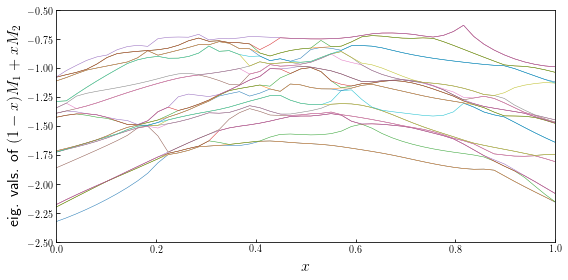

In [56]:
fig, ax = plt.subplots(figsize=(8, 4))

for idx in range(evals.shape[1]):
    ax.plot(x_vec, np.real(evals[:,idx]), lw=0.5)

ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel(r"eig. vals. of $(1-x)M_1+xM_2$", fontsize=16)
ax.set_xlim(0, 1)
ax.set_ylim(-2.5, -0.5)
ax.tick_params(which='both', direction='in')

fig.tight_layout()

## Graphs and networks

Representing graphs as adjacency matrices is another important application of sparse matrices. In an
adjacency matrix an element describes which nodes in a graph are connected to each other. Consequently,
if each node is only connected to a small set of other nodes the adjacency matrix is sparse.
The `csgraph` module in the Scipy `sparse` module provides functions for processing such graphs, including methods for
traversing a graph using different methods (breadth-first and depth-first traversals, for example) and for
computing shortest paths between nodes in a graph, and so on.

For a more comprehensive framework for working with graphs, there is the `NetworkX` Python library.
It provides utilities for creating and manipulating undirected and directed graphs, and also implements
many graph algorithms, such as finding minimum paths between nodes in a graph. Here we assume that
the networkx library is imported under the name `nx`. Using this library, we can, for example, create an
undirected graph by initiating an object of the class `nx.Graph`. Any hashable Python object can be stored as
nodes in a Graph object, which makes it very flexible data structure.

For example, we can create a simple graph with node data that are integers using `nx.Graph()`, and
the `add_node` method, or `add_nodes_from` to add multiple nodes in one go. The `nodes` method returns a
list of nodes:

In [57]:
g = nx.Graph()
g.add_node(1)
g.nodes()

[1]

In [58]:
g.add_nodes_from([3, 4, 5])
g.nodes()

[1, 3, 4, 5]

To connect nodes we can add edges, using `add_edge`. We pass the labels of the two nodes we want to
connect as arguments. To add multiple edges we can use `add_edges_from`, and pass to it a list of tuples of
nodes to connect. The `edges` method returns a list of edges:

In [59]:
g.add_edge(1, 2)
g.edges()

[(1, 2)]

In [60]:
g.add_edges_from([(3, 4), (5, 6)])
g.edges()

[(1, 2), (3, 4), (5, 6)]

To represent edges between nodes that have weights associated with them (for example, a distance), we
can use `add_weighted_edges_from`, to which we pass a list of tuples that also contains the weight factor for
each edge, in addition to the two nodes. When calling the `edges` method, we can additionally give argument
`data=True` to indicate that also the edge data should be included in the resulting list.

In [61]:
g.add_weighted_edges_from([(1, 3, 1.5), (3, 5, 2.5)])
g.edges(data=True)

[(1, 2, {}),
 (1, 3, {'weight': 1.5}),
 (3, 4, {}),
 (3, 5, {'weight': 2.5}),
 (5, 6, {})]

Note that if we add edges between nodes that do not yet exist in the graph, they are seamlessly added.
For example, in the following code we add a weighted edge between node 6 and 7. Node 7 does not previously
exist in the graph, but when adding an edge to it, it is automatically created and added to the graph:

In [62]:
g.add_weighted_edges_from([(6, 7, 1.5)])
g.nodes()

[1, 2, 3, 4, 5, 6, 7]

In [63]:
g.edges()

[(1, 2), (1, 3), (3, 4), (3, 5), (5, 6), (6, 7)]

With these basic fundamentals in place, we are already prepared to look at a more complicated example
of a graph. In the following we will build a graph from a dataset stored in a JSON file called
`tokyo-metro.json`, which we load using the Python standard library module `json`:

In [64]:
import json
with open("./files/tokyo-metro.json") as f:
    data = json.load(f)

The result of loading the JSON file is a dictionary `data` that contains metro line descriptions. For each
line, there is a list of travel times between stations (`travel_times`), a list of possible transfer points to other
lines (`transfer`), as well as the line color:

In [65]:
data.keys()

dict_keys(['F', 'T', 'C', 'M', 'Z', 'N', 'Y', 'H', 'G'])

In [66]:
data["C"]

{'color': '#149848',
 'transfers': [['C3', 'F15'],
  ['C4', 'Z2'],
  ['C4', 'G2'],
  ['C7', 'M14'],
  ['C7', 'N6'],
  ['C7', 'G6'],
  ['C8', 'M15'],
  ['C8', 'H6'],
  ['C9', 'H7'],
  ['C9', 'Y18'],
  ['C11', 'T9'],
  ['C11', 'M18'],
  ['C11', 'Z8'],
  ['C12', 'M19'],
  ['C18', 'H21']],
 'travel_times': [['C1', 'C2', 2],
  ['C2', 'C3', 2],
  ['C3', 'C4', 1],
  ['C4', 'C5', 2],
  ['C5', 'C6', 2],
  ['C6', 'C7', 2],
  ['C7', 'C8', 1],
  ['C8', 'C9', 3],
  ['C9', 'C10', 1],
  ['C10', 'C11', 2],
  ['C11', 'C12', 2],
  ['C12', 'C13', 2],
  ['C13', 'C14', 2],
  ['C14', 'C15', 2],
  ['C15', 'C16', 2],
  ['C16', 'C17', 3],
  ['C17', 'C18', 3],
  ['C18', 'C19', 3]]}

The format of the `transfers` list is `[['C3', 'F15'], ...]`, indicating that it is possible
to transfer from C line to F line at station C3 to station F15. 
The format of the `travel_times` list is `[['C1', 'C2', 2], ['C2', 'C3', 2], ...]`, indicating that
it takes two minutes to travel between the stations C1 and C2, and two minutes to travel between
C2 and C3, etc. The `transfers` and `travel_times` are
directly suitable for feeding to `add_weighed_edges_from` and `add_edges_from`, and we can therefore easily
create a graph for representing the metro network by iterating over each metro line dictionary and call
these methods:

In [67]:
g = nx.Graph()

for line in data.values():
    g.add_edges_from(line["transfers"])    
    g.add_weighted_edges_from(line["travel_times"])

In [68]:
g.edges(data=True)

[('N14', 'N13', {'weight': 2}),
 ('N14', 'N15', {'weight': 3}),
 ('H8', 'H9', {'weight': 2}),
 ('H8', 'H7', {'weight': 1}),
 ('H8', 'G9', {}),
 ('H8', 'M16', {}),
 ('T21', 'T22', {'weight': 43}),
 ('T21', 'T20', {'weight': 41}),
 ('F9', 'F10', {'weight': 3}),
 ('F9', 'M25', {}),
 ('F9', 'Y9', {}),
 ('F9', 'F8', {'weight': 2}),
 ('N13', 'N12', {'weight': 2}),
 ('F10', 'F11', {'weight': 2}),
 ('C6', 'C5', {'weight': 2}),
 ('C6', 'C7', {'weight': 2}),
 ('G4', 'G5', {'weight': 2}),
 ('G4', 'Z3', {}),
 ('G4', 'G3', {'weight': 2}),
 ('T5', 'T4', {'weight': 9}),
 ('T5', 'T6', {'weight': 11}),
 ('M13', 'M14', {'weight': 2}),
 ('M13', 'Y16', {}),
 ('M13', 'M12', {'weight': 3}),
 ('M13', 'N7', {}),
 ('M13', 'Z4', {}),
 ('M13', 'G5', {}),
 ('C17', 'C18', {'weight': 3}),
 ('C17', 'C16', {'weight': 3}),
 ('Z13', 'Z14', {'weight': 2}),
 ('Z13', 'Z12', {'weight': 2}),
 ('N6', 'M14', {}),
 ('N6', 'C7', {}),
 ('N6', 'N5', {'weight': 2}),
 ('N6', 'N7', {'weight': 2}),
 ('N6', 'G6', {}),
 ('G1', 'G2', {'

The line transfer edges do not have edge weights, so let's first mark all transfer edges by adding a new Boolean attribute `transfer` to each edge:

In [69]:
for n1, n2 in g.edges_iter():
    g[n1][n2]["transfer"] = "weight" not in g[n1][n2]

In [70]:
g.edges(data=True)

[('N14', 'N13', {'transfer': False, 'weight': 2}),
 ('N14', 'N15', {'transfer': False, 'weight': 3}),
 ('H8', 'H9', {'transfer': False, 'weight': 2}),
 ('H8', 'H7', {'transfer': False, 'weight': 1}),
 ('H8', 'G9', {'transfer': True}),
 ('H8', 'M16', {'transfer': True}),
 ('T21', 'T22', {'transfer': False, 'weight': 43}),
 ('T21', 'T20', {'transfer': False, 'weight': 41}),
 ('F9', 'F10', {'transfer': False, 'weight': 3}),
 ('F9', 'M25', {'transfer': True}),
 ('F9', 'Y9', {'transfer': True}),
 ('F9', 'F8', {'transfer': False, 'weight': 2}),
 ('N13', 'N12', {'transfer': False, 'weight': 2}),
 ('F10', 'F11', {'transfer': False, 'weight': 2}),
 ('C6', 'C5', {'transfer': False, 'weight': 2}),
 ('C6', 'C7', {'transfer': False, 'weight': 2}),
 ('G4', 'G5', {'transfer': False, 'weight': 2}),
 ('G4', 'Z3', {'transfer': True}),
 ('G4', 'G3', {'transfer': False, 'weight': 2}),
 ('T5', 'T4', {'transfer': False, 'weight': 9}),
 ('T5', 'T6', {'transfer': False, 'weight': 11}),
 ('M13', 'M14', {'trans

In [71]:
g.number_of_nodes()

184

In [72]:
g.nodes()[:5]

['N14', 'H8', 'T21', 'F9', 'N13']

In [73]:
g.number_of_edges()

243

In [74]:
g.edges()[:5]

[('N14', 'N13'), ('N14', 'N15'), ('H8', 'H9'), ('H8', 'H7'), ('H8', 'G9')]

Next, for plotting purposes, we create two lists of edges containing transfer edges and on-train edges:

In [75]:
on_foot = [edge for edge in g.edges_iter() if g.get_edge_data(*edge)["transfer"]]
on_train = [edge for edge in g.edges_iter() if not g.get_edge_data(*edge)["transfer"]]

and we also create a list with colors corresponding to each node in the network:

In [76]:
colors = [data[n[0].upper()]["color"] for n in g.nodes()]

To visualize the graph we can use the Matplotlib-based drawing routines in the `networkx` library:
We use `nx.draw_networkx` to draw each node, `nx.draw_networkx_labels` to draw the labels to the nodes, 
`nx.draw_network_edges` to draw the edges. We call `nx.draw_network_edges` twice, with the edge lists for transfers
(`on_foot`) and on-train (`on_train`) connections, and color the links as blue and black, respectively, using the
`edge_color` argument. The layout of the graph is determined by the `pos` argument to the drawing functions.
Here we used the `graphviz_layout` to layout the nodes. All drawing functions also accept a Matplotlib
axes instance via the `ax` argument.

In [77]:
from networkx.drawing.nx_agraph import graphviz_layout

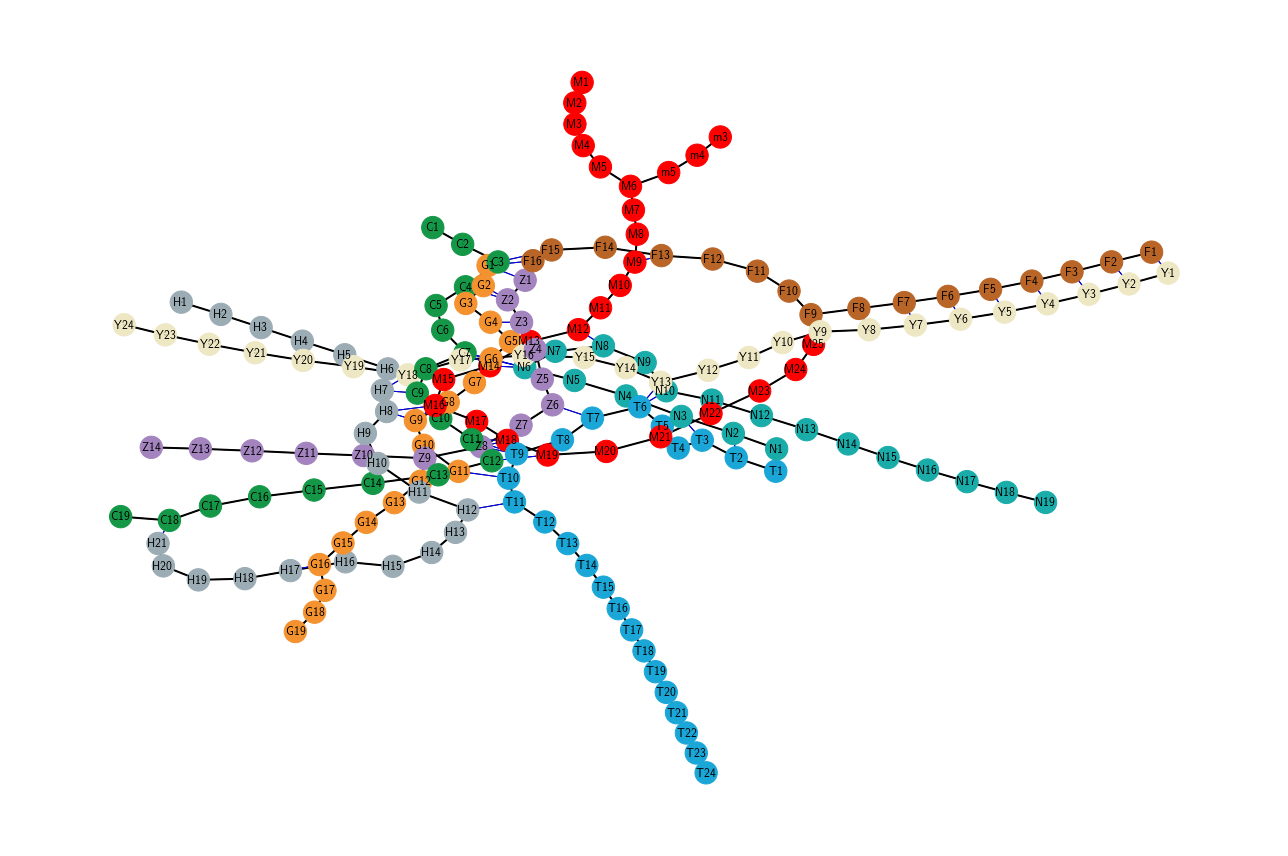

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

pos = graphviz_layout(g, prog="neato")
nx.draw_networkx(g, pos, ax=ax, node_size=500, node_color=colors)
nx.draw_networkx_labels(g, pos=pos, ax=ax, font_size=1)
nx.draw_networkx_edges(g, pos=pos, ax=ax, edgelist=on_train, width=2)
nx.draw_networkx_edges(g, pos=pos, ax=ax, edgelist=on_foot, edge_color="blue")

# removing the default axis on all sides:
for side in ['bottom','right','top','left']:
    ax.spines[side].set_visible(False)

# removing the axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

fig.tight_layout()

Once the network has been constructed, we can use the many graph algorithms provided by the
NetworkX library to analyze the network. For example, to compute the degree (that is, the number of
connections to a node) of each node, we can use the `degree` method

In [79]:
g.degree()

{'C1': 1,
 'C10': 2,
 'C11': 5,
 'C12': 3,
 'C13': 2,
 'C14': 2,
 'C15': 2,
 'C16': 2,
 'C17': 2,
 'C18': 3,
 'C19': 1,
 'C2': 2,
 'C3': 3,
 'C4': 4,
 'C5': 2,
 'C6': 2,
 'C7': 5,
 'C8': 4,
 'C9': 4,
 'F1': 2,
 'F10': 2,
 'F11': 2,
 'F12': 2,
 'F13': 3,
 'F14': 2,
 'F15': 3,
 'F16': 3,
 'F2': 3,
 'F3': 3,
 'F4': 3,
 'F5': 3,
 'F6': 3,
 'F7': 3,
 'F8': 3,
 'F9': 4,
 'G1': 3,
 'G10': 2,
 'G11': 3,
 'G12': 3,
 'G13': 2,
 'G14': 2,
 'G15': 3,
 'G16': 3,
 'G17': 2,
 'G18': 2,
 'G19': 1,
 'G2': 4,
 'G3': 2,
 'G4': 3,
 'G5': 6,
 'G6': 5,
 'G7': 2,
 'G8': 2,
 'G9': 4,
 'H1': 1,
 'H10': 2,
 'H11': 2,
 'H12': 3,
 'H13': 2,
 'H14': 2,
 'H15': 2,
 'H16': 3,
 'H17': 3,
 'H18': 2,
 'H19': 2,
 'H2': 2,
 'H20': 2,
 'H21': 2,
 'H3': 2,
 'H4': 2,
 'H5': 2,
 'H6': 4,
 'H7': 4,
 'H8': 4,
 'H9': 2,
 'M1': 1,
 'M10': 2,
 'M11': 2,
 'M12': 3,
 'M13': 6,
 'M14': 5,
 'M15': 4,
 'M16': 4,
 'M17': 2,
 'M18': 5,
 'M19': 3,
 'M2': 2,
 'M20': 2,
 'M21': 2,
 'M22': 3,
 'M23': 2,
 'M24': 2,
 'M25': 3,
 'M3': 2,
 'M4'

For this graph, the degree of a node can be interpreted as the number of connections to a station. We can
easily search for the most highly connected station in the network by using the `degree method`, the `values`
method of the resulting Python dictionary, and the `max` function to find the highest degree in the network.

In [80]:
d_max = max(g.degree().values())
[(n, d) for (n, d) in g.degree().items() if d == d_max]

[('M13', 6), ('G5', 6), ('N7', 6), ('Y16', 6), ('Z4', 6)]

We can also compute the closest path between two points in the network using `nx.shortest_path`. For example, the optimal
traveling route (assuming no waiting time and instantaneous transfer) for traveling between `Y24` and `C19` is:

In [81]:
p = nx.shortest_path(g, "Y24", "C19"); p

['Y24',
 'Y23',
 'Y22',
 'Y21',
 'Y20',
 'Y19',
 'Y18',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19']

Given a path on this form, we can also directly evaluate the travel time by summing up the weight
attributes of neighboring nodes in the path:

In [82]:
np.sum([g[p[n]][p[n+1]]["weight"] for n in range(len(p)-1) if "weight" in g[p[n]][p[n+1]]])

35

The result suggests that it takes 35 minutes to travel from `Y24` to `C19`. Since the transfer nodes do not
have a weight associated with them, the train transfers are effectively assumed to be instantaneous. It may be
reasonable to assume that a train transfer takes about 5 minutes, and to take this into account in the shortest
path and travel time computation we can update the transfer nodes and add a weight of 5 to each of them.
To do this we create a copy of the graph using the `copy` method, and iterate through the edges and update
those with `transfer` attribute set to `True`:

In [87]:
h = g.copy()
for n1, n2 in h.edges_iter():
    if h[n1][n2]["transfer"]:
        h[n1][n2]["weight"] = 5
p = nx.shortest_path(h, "Y24", "C19"); p

['Y24',
 'Y23',
 'Y22',
 'Y21',
 'Y20',
 'Y19',
 'Y18',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19']

In [88]:
np.sum([h[p[n]][p[n+1]]["weight"] for n in range(len(p)-1)])

40

With this method, we can of course compute the optimal path and travel time between arbitrary nodes
in the network. As another example, we also compute the shortest path and traveling time between Z1 and
H16 (32 minutes):

In [89]:
p = nx.shortest_path(h, "Z1", "H16")
np.sum([h[p[n]][p[n+1]]["weight"] for n in range(len(p)-1)])

32

The NetworkX representation of a graph can be converted to an adjacency matrix in the form of a Scipy
sparse matrix using the `nx.to_scipy_sparse_matrix`, after which we can also analyze the graph with the
routines in the `sp.csgraph` module. As an example of this, we convert the Tokyo Metro graph to an adjacency
matrix and compute its reverse Cuthill-McKee ordering (using `sp.csgraph.reverse_cuthill_mckee`, which is a reordering that reduces the maximum distance of the matrix elements from the diagonal), and permute the matrix with this ordering.

In [90]:
A = nx.to_scipy_sparse_matrix(g); A

<184x184 sparse matrix of type '<class 'numpy.int32'>'
	with 486 stored elements in Compressed Sparse Row format>

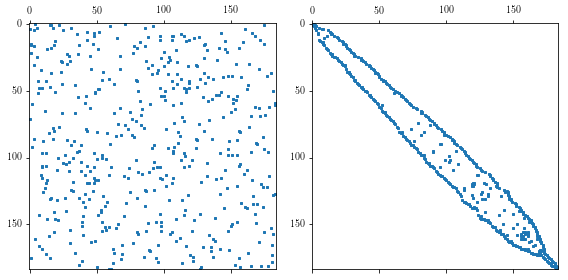

In [91]:
perm = sp.csgraph.reverse_cuthill_mckee(A)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.spy(A, markersize=2)
ax2.spy(sp_permute(A, perm, perm), markersize=2)

fig.tight_layout()

## Versions

In [92]:
%reload_ext version_information
%version_information numpy, scipy, matplotlib, networkx, pygraphviz

Software versions
Python 3.4.2 32bit [GCC 4.9.1]
IPython 6.0.0
OS Linux 4.9.24 v7+ armv7l with debian 8.0
numpy 1.12.1
scipy 0.19.0
matplotlib 2.0.2
networkx 1.11
pygraphviz 1.3.1
Mon May 15 11:35:39 2017 KST